In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/Assignment/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/Assignment


In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
import torch.nn.functional as F
import torch.nn as nn
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),         
            nn.BatchNorm2d(16),   
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),         
            nn.BatchNorm2d(16),   
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
        ) # output_size = 8
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),         
            nn.BatchNorm2d(16),   
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),        
            nn.BatchNorm2d(12),    
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
            ) 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

In [0]:
import torch
from tqdm import tqdm

train_losses = []
train_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = torch.nn.functional.nll_loss(y_pred, target)
    l1_crit = torch.nn.L1Loss(size_average=False)
    reg_loss=0
    for param in model.parameters():
      zero_vector = torch.rand_like(param)*0
      reg_loss += l1_crit(param, zero_vector)
    factor = 0.0005
    loss += factor*reg_loss
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

test_acc = []
test_losses = []

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=7, gamma=0.5)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.55816650390625 Batch_id=468 Accuracy=84.95: 100%|██████████| 469/469 [00:16<00:00, 33.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1494, Accuracy: 9604/10000 (96.04%)

EPOCH: 1


Loss=0.6098546981811523 Batch_id=468 Accuracy=90.12: 100%|██████████| 469/469 [00:16<00:00, 37.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1703, Accuracy: 9529/10000 (95.29%)

EPOCH: 2


Loss=0.5745640993118286 Batch_id=468 Accuracy=90.48: 100%|██████████| 469/469 [00:16<00:00, 28.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.4027, Accuracy: 8338/10000 (83.38%)

EPOCH: 3


Loss=0.5034807920455933 Batch_id=468 Accuracy=90.60: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1886, Accuracy: 9456/10000 (94.56%)

EPOCH: 4


Loss=0.4032289385795593 Batch_id=468 Accuracy=90.43: 100%|██████████| 469/469 [00:15<00:00, 28.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1285, Accuracy: 9685/10000 (96.85%)

EPOCH: 5


Loss=0.5750696659088135 Batch_id=468 Accuracy=90.58: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1633, Accuracy: 9547/10000 (95.47%)

EPOCH: 6


Loss=0.5764076709747314 Batch_id=468 Accuracy=90.46: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1691, Accuracy: 9538/10000 (95.38%)

EPOCH: 7


Loss=0.3948304057121277 Batch_id=468 Accuracy=92.03: 100%|██████████| 469/469 [00:16<00:00, 28.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1170, Accuracy: 9682/10000 (96.82%)

EPOCH: 8


Loss=0.5073013305664062 Batch_id=468 Accuracy=91.75: 100%|██████████| 469/469 [00:16<00:00, 27.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0912, Accuracy: 9760/10000 (97.60%)

EPOCH: 9


Loss=0.5793246030807495 Batch_id=468 Accuracy=91.61: 100%|██████████| 469/469 [00:16<00:00, 29.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1640, Accuracy: 9492/10000 (94.92%)

EPOCH: 10


Loss=0.434982031583786 Batch_id=468 Accuracy=91.87: 100%|██████████| 469/469 [00:15<00:00, 36.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0866, Accuracy: 9760/10000 (97.60%)

EPOCH: 11


Loss=0.42175406217575073 Batch_id=468 Accuracy=91.65: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1079, Accuracy: 9739/10000 (97.39%)

EPOCH: 12


Loss=0.4707828164100647 Batch_id=468 Accuracy=91.71: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2362, Accuracy: 9554/10000 (95.54%)

EPOCH: 13


Loss=0.4007667899131775 Batch_id=468 Accuracy=92.12: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Accuracy: 9841/10000 (98.41%)

EPOCH: 14


Loss=0.36636632680892944 Batch_id=468 Accuracy=92.60: 100%|██████████| 469/469 [00:15<00:00, 30.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0724, Accuracy: 9793/10000 (97.93%)

EPOCH: 15


Loss=0.37130242586135864 Batch_id=468 Accuracy=92.59: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0922, Accuracy: 9755/10000 (97.55%)

EPOCH: 16


Loss=0.43299704790115356 Batch_id=468 Accuracy=92.45: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0760, Accuracy: 9818/10000 (98.18%)

EPOCH: 17


Loss=0.32469385862350464 Batch_id=468 Accuracy=92.53: 100%|██████████| 469/469 [00:15<00:00, 30.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1126, Accuracy: 9707/10000 (97.07%)

EPOCH: 18


Loss=0.3983203172683716 Batch_id=468 Accuracy=92.65: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0938, Accuracy: 9724/10000 (97.24%)

EPOCH: 19


Loss=0.3997178375720978 Batch_id=468 Accuracy=92.67: 100%|██████████| 469/469 [00:15<00:00, 30.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0863, Accuracy: 9747/10000 (97.47%)

EPOCH: 20


Loss=0.4456885755062103 Batch_id=468 Accuracy=92.53: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0876, Accuracy: 9768/10000 (97.68%)

EPOCH: 21


Loss=0.3213704824447632 Batch_id=468 Accuracy=93.72: 100%|██████████| 469/469 [00:15<00:00, 30.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9871/10000 (98.71%)

EPOCH: 22


Loss=0.2621600031852722 Batch_id=468 Accuracy=93.26: 100%|██████████| 469/469 [00:15<00:00, 29.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0764, Accuracy: 9793/10000 (97.93%)

EPOCH: 23


Loss=0.2782842218875885 Batch_id=468 Accuracy=93.22: 100%|██████████| 469/469 [00:15<00:00, 29.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9858/10000 (98.58%)

EPOCH: 24


Loss=0.2786955237388611 Batch_id=468 Accuracy=93.23: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0658, Accuracy: 9840/10000 (98.40%)

EPOCH: 25


Loss=0.1983625590801239 Batch_id=468 Accuracy=93.08: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9843/10000 (98.43%)

EPOCH: 26


Loss=0.392461359500885 Batch_id=468 Accuracy=93.15: 100%|██████████| 469/469 [00:15<00:00, 29.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1021, Accuracy: 9714/10000 (97.14%)

EPOCH: 27


Loss=0.4033297896385193 Batch_id=468 Accuracy=93.07: 100%|██████████| 469/469 [00:16<00:00, 29.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0749, Accuracy: 9796/10000 (97.96%)

EPOCH: 28


Loss=0.35054510831832886 Batch_id=468 Accuracy=93.72: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0658, Accuracy: 9805/10000 (98.05%)

EPOCH: 29


Loss=0.32660815119743347 Batch_id=468 Accuracy=93.84: 100%|██████████| 469/469 [00:15<00:00, 35.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9887/10000 (98.87%)

EPOCH: 30


Loss=0.21273846924304962 Batch_id=468 Accuracy=93.83: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0592, Accuracy: 9844/10000 (98.44%)

EPOCH: 31


Loss=0.24855393171310425 Batch_id=468 Accuracy=93.70: 100%|██████████| 469/469 [00:15<00:00, 29.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9885/10000 (98.85%)

EPOCH: 32


Loss=0.25999969244003296 Batch_id=468 Accuracy=93.57: 100%|██████████| 469/469 [00:16<00:00, 38.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0733, Accuracy: 9778/10000 (97.78%)

EPOCH: 33


Loss=0.36555492877960205 Batch_id=468 Accuracy=93.48: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9860/10000 (98.60%)

EPOCH: 34


Loss=0.24029448628425598 Batch_id=468 Accuracy=93.78: 100%|██████████| 469/469 [00:15<00:00, 29.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9862/10000 (98.62%)

EPOCH: 35


Loss=0.25823235511779785 Batch_id=468 Accuracy=94.27: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9898/10000 (98.98%)

EPOCH: 36


Loss=0.28846275806427 Batch_id=468 Accuracy=93.92: 100%|██████████| 469/469 [00:15<00:00, 31.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9900/10000 (99.00%)

EPOCH: 37


Loss=0.3680408000946045 Batch_id=468 Accuracy=94.01: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9863/10000 (98.63%)

EPOCH: 38


Loss=0.2584541440010071 Batch_id=468 Accuracy=94.06: 100%|██████████| 469/469 [00:15<00:00, 30.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9907/10000 (99.07%)

EPOCH: 39


Loss=0.23253926634788513 Batch_id=468 Accuracy=93.88: 100%|██████████| 469/469 [00:15<00:00, 38.69it/s]



Test set: Average loss: 0.0439, Accuracy: 9874/10000 (98.74%)



Text(0, 0.5, 'Accuracy')

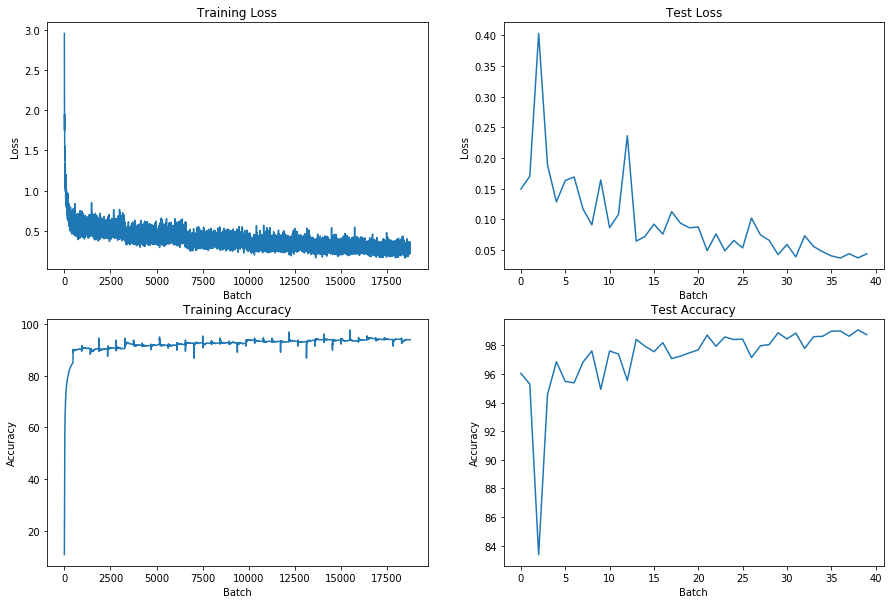

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].set_xlabel("Batch")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[1, 0].set_xlabel("Batch")
axs[1, 0].set_ylabel("Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[0, 1].set_xlabel("Batch")
axs[0, 1].set_ylabel("Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")
axs[1, 1].set_xlabel("Batch")
axs[1, 1].set_ylabel("Accuracy")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  app.launch_new_instance()


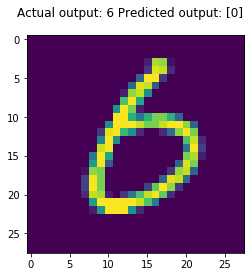

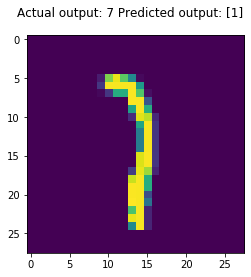

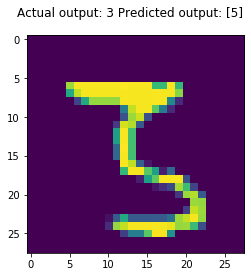

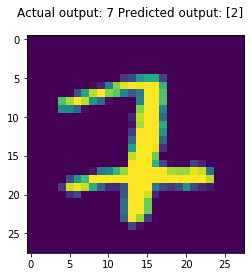

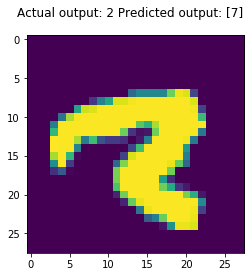

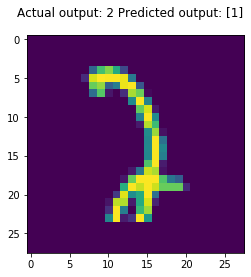

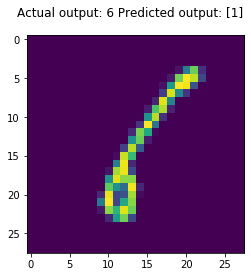

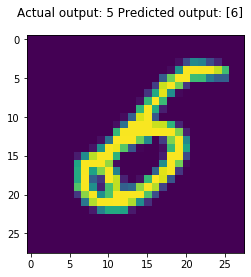

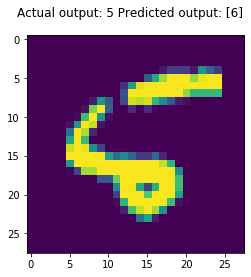

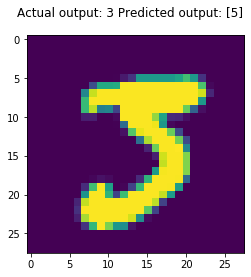

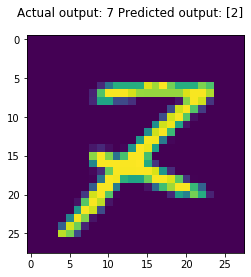

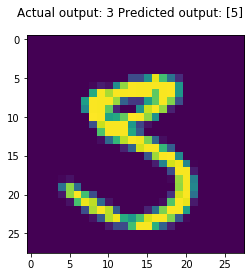

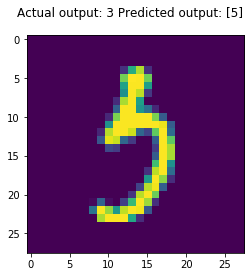

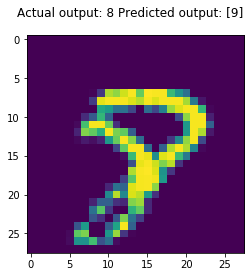

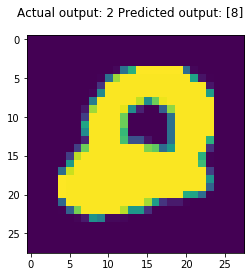

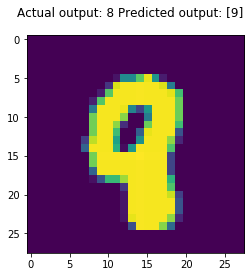

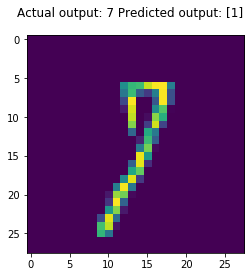

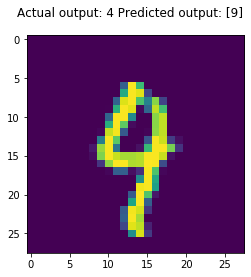

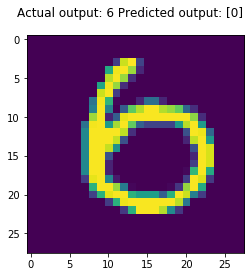

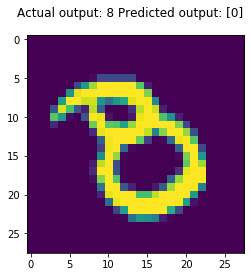

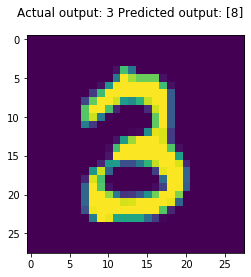

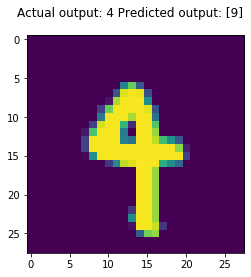

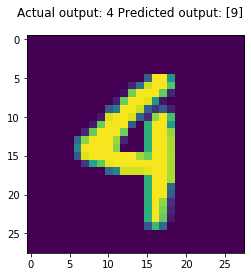

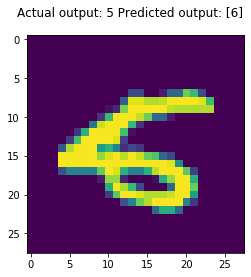

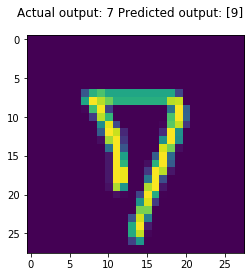

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
with torch.no_grad():
        count = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            targetx = target.cpu().numpy()
            predx = pred.cpu().numpy()
            for i, j in enumerate(targetx):
              if count==25:
                  break
              if targetx[i] != predx[i]:
                fig = plt.figure()
                plt.imshow(np.transpose(data[i].cpu().detach().numpy(), (1, 2, 0)).reshape(28,28))
                fig.suptitle("Actual output: " + str(targetx[i]) + " Predicted output: " + str(predx[i]))
                fig.savefig(str(count)+".jpg")
                files.download(str(count)+".jpg")
                count = count+1
              

In [0]:
rm -rf *.jpg